# Start pandexo simulations of modelled spectra to get simulated JWST/MIRI observations


## Install and setup pandexo on WSL (03/02/2022)

1. It seems like the pandexo's web GUI is broken, as the example shown in [Ryan's pandexo tutorial](https://drive.google.com/drive/folders/12pbji-dg5XblqhSXzKmZ2nv_uvTi2N-b) is no longer working
2. Got pandexo to install through the following steps:
    1. Added 'export ...' statements to the ~/.profile file, with full paths. 
    2. Created a new conda environment
    3. conda config --add channels http://ssb.stsci.edu/astroconda
    4. conda install pyfftw
    5. pip install pandexo.engine
    6. Download 'run_test.py' from pandexo's Github repo and try to run it.
    7. Now, running 'python run_test.py' gives out an astropy error, as the latest version's module names have been changed. So, downgrade astropy using 'pip install astropy==4.1rc1' (This is the version from summer 2020 when the code was working..)
    8. It should work now


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import pandexo.engine.justplotit as jpi
import matplotlib.pyplot as plt
import astropy
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter, NullFormatter
from scipy.ndimage import gaussian_filter1d as gauss_conv
import pickle as pk
import numpy as np
import pandas as pd
import scipy.constants as sc
from spectres import spectres 

import matplotlib

plt.style.use('classic')
plt.rc('font', family='serif')
matplotlib.rcParams['svg.fonttype'] = 'none'

### Follow the tutorial in pandexo's documentation to get secondary eclipse data for GJ1214b (since we have a stellar file for this planet)

Setting up a run

In [2]:
exo_dict = jdi.load_exo_dict()
print(exo_dict.keys())
#print(exo_dict['star']['w_unit'])

dict_keys(['calculation', 'url', 'url_err', 'star', 'planet', 'observation'])


Exoplanet observation inputs

In [4]:
exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 3.48*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Exoplanet host star inputs

In [5]:
fits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')
data = fits_image_filename[1].data
wav = np.array([data[i][0] for i in range(5000)])
Flux_lambda = np.array([data[i][1] for i in range(5000)])
nu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)
Flux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz

def write_stellar(nu, F_nu):
    
    # Write spectrum
    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')
    
    for i in range(len(nu)):
        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))

write_stellar(wav*(10**-4), Flux_nu)

In [6]:
exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './Resources/GJ1214_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'erg/cm2/s/Hz'      
exo_dict['star']['mag'] = 9.750             # Magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

Exoplanet planet inputs for secondary eclipse

In [9]:
exo_dict['planet']['f_unit'] = 'fp/f*'
exo_dict['planet']['temp'] = 700

Exoplanet planet inputs for transit model

In [8]:
def read_spectrum_Caroline(fname, R_p, R_s ):
    data=pd.read_csv(fname , sep = '\s+', skiprows = 1, header= None)
    wavelength = np.array(data[0])
    H_eff = np.array(data[1])
    spectrum = (H_eff*1.0e3)**2/ R_s**2
 
    return wavelength, spectrum

def write_output(spectrum, wl):
    
    '''Writes out a given model PT profile and spectrum'''
    
    # Write spectrum
    f = open('./Resources/' 'GJ1214_transmission.txt','w')
    
    for i in range(len(wl)):
        f.write('%.8e %.8e \n' %(wl[i], spectrum[i]))   # wl (um) | Rp/Rs^2
        
    f.close()

spectrum_file = './Resources/gj1214-kzz8-1x-r0.03-f10_soot.out'

R_J = 7.1492e7     # Radius of Jupiter (m)
R_p = 0.241*R_J   # Radius of planet
R_Sun = 6.957e8    # Radius of Sun (m)
R_s = 0.22*R_Sun     # Radius of star (m)


wl, spectrum = read_spectrum_Caroline(spectrum_file, R_p, R_s)

write_output(spectrum, wl)
    
spectrum_file_processed = './Resources/GJ1214_transmission.txt'


exo_dict['planet']['type'] ='user'
exo_dict['planet']['exopath'] = spectrum_file_processed
exo_dict['planet']['w_unit'] = 'um'                        # Other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'                 # Other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.8688*60*60.0          # Transit duration
exo_dict['planet']['td_unit'] = 's'                        # Any unit of time in accordance with astropy.units can be added

Select instrument

In [9]:
#inst_dict = ['MIRI LRS']
inst_dict = jdi.load_mode_dict('NIRSpec G395H')

Run pandexo

In [10]:
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


Plot results

In [13]:
#load in output from run
out = pk.load(open('./pandexo_outputs/singlerun.p','rb'))
#for a single run
x,y, e = jpi.jwst_1d_spec(out, R=100, num_tran=1, model=False)

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/g/My Drive/Work/Research/Projects/Rocky_exo_JWST/d ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


<ErrorbarContainer object of 3 artists>

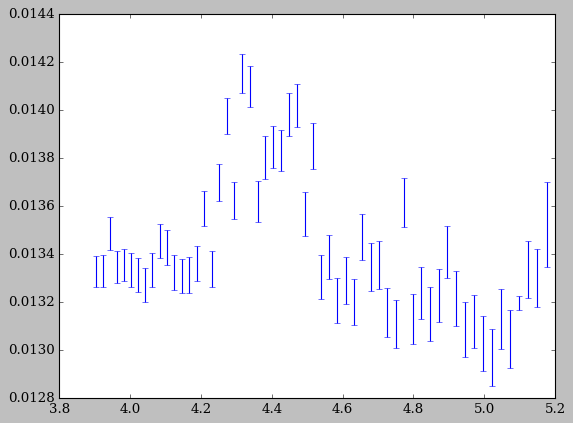

In [23]:
plt.figure()
plt.errorbar(x[0][60:],y[0][60:],yerr=e[0][60:],ls='')

### The transmission spectrum simulation is working, try emission now

Setting up a run

In [2]:
exo_dict = jdi.load_exo_dict()
print(exo_dict.keys())
#print(exo_dict['star']['w_unit'])

dict_keys(['calculation', 'url', 'url_err', 'star', 'planet', 'observation'])


Exoplanet observation inputs

In [3]:
exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = 1 #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 3.48*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 10   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Exoplanet host star inputs

In [4]:
fits_image_filename = astropy.io.fits.open('./Resources/GJ1214_stellar_spectrum.fits')
data = fits_image_filename[1].data
wav = np.array([data[i][0] for i in range(5000)])
Flux_lambda = np.array([data[i][1] for i in range(5000)])
nu = sc.c / (wav*1.0e-10)     # Convert wavelength (in Angstrom) into frequency (Hz)
Flux_nu = Flux_lambda * ((sc.c*1e10) / nu**2)   # Speed of light in Angstrom HZ converts from erg/cm^2/s/Angstrom into erg/cm^2/s/Hz

def write_stellar(nu, F_nu):
    
    # Write spectrum
    f = open('./Resources/'  + 'GJ1214_stellar.dat','w')
    
    for i in range(len(nu)):
        f.write('%.8e %.8e \n' %(nu[i], F_nu[i]))

write_stellar(wav*(10**-4), Flux_nu)

In [5]:
exo_dict['star']['type'] = 'user'        # Phoenix or user (if you have your own)
exo_dict['star']['starpath'] = './Resources/GJ1214_stellar.dat'
exo_dict['star']['w_unit'] = 'um'                      
exo_dict['star']['f_unit'] = 'erg/cm2/s/Hz'      
exo_dict['star']['mag'] = 9.750             # Magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         # For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)

Exoplanet planet input for secondary eclipse

In [17]:
exo_dict['planet']['type'] = 'constant'   
exo_dict['planet']['transit_duration'] = 0.8688*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'
exo_dict['planet']['radius'] = 0.241
exo_dict['planet']['r_unit'] = 'R_jup'            #Any unit of distance in accordance with astropy.units can be added here
exo_dict['star']['radius'] = 0.22
exo_dict['star']['r_unit'] = 'R_sun'              #Same deal with astropy.units here
exo_dict['planet']['f_unit'] = 'fp/f*'
exo_dict['planet']['temp'] = 700

Select instrument

In [18]:
inst_dict = jdi.load_mode_dict('MIRI LRS')

In [19]:
result = jdi.run_pandexo(exo_dict, inst_dict, output_path = './pandexo_outputs/', output_file='GJ1214b_emission.p')

Running Single Case w/ User Instrument Dict
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [22]:
#load in output from run
out = pk.load(open('./pandexo_outputs/GJ1214b_emission.p','rb'))
#for a single run
x,y,e = jpi.jwst_1d_spec(out, R=100, num_tran=1, model=False, plot=False)

<ErrorbarContainer object of 3 artists>

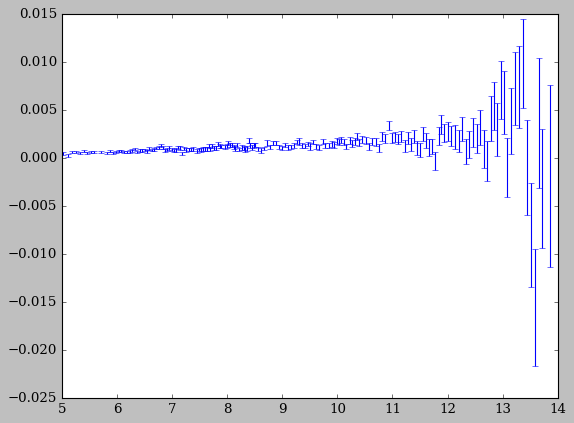

In [26]:
plt.figure()
plt.errorbar(x[0],y[0],yerr=e[0], ls='')

### Great, this works too! Now on to simulating one for LHS-3844b...